#  MNIST Digit Classifier — Built From Scratch Using NumPy  
A simple Multilayer Perceptron implemented manually (Forward + Backprop + Adam)

This notebook demonstrates:

- Loading MNIST from custom CSV  
- Implementing activation functions  
- Implementing Cross-Entropy Loss  
- Building an MLP from scratch  
- Training with Adam optimizer  
- Evaluating and visualizing the results  

---


In [1]:
import numpy as np

# ------------------------
# 1) تابع one-hot
# ------------------------
def to_one_hot(y, num_classes=10):
    y = y.astype(int)
    one_hot = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    one_hot[np.arange(y.shape[0]), y] = 1.0
    return one_hot


# ------------------------
# 2) تابع لود داده از CSV (نسخه با genfromtxt)
# ------------------------
def load_mnist_csv(path, test_ratio=0.2, shuffle=True):
    """
    ساختار CSV شما:

    col0 = estimated labels (خالی)  ❌ استفاده نمی‌کنیم
    col1 = label (0..9)             ✅
    col2... = pixel values          ✅

    خروجی:
        (X_train, y_train_oh), (X_test, y_test_oh)
    """

    # genfromtxt با filling_values باعث می‌شود سلول‌های خالی → 0 بشوند
    data = np.genfromtxt(
        path,
        delimiter=",",
        skip_header=1,   # اگر header نداری، این را بکن 0
        filling_values=0 # خالی‌ها را با 0 پر کن
    )

    # اگر فایل خیلی بزرگ باشد، بد نیست این را چک کنیم:
    print("Raw data shape:", data.shape)

    # ستون 0 → دور ریخته می‌شود
    labels = data[:, 1]          # ستون لیبل
    pixels = data[:, 2:]         # پیکسل‌ها

    # نرمال‌سازی 0..255 → 0..1
    pixels = pixels.astype(np.float32) / 255.0

    # شافل
    N = pixels.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    test_size = int(N * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    X_train = pixels[train_indices]
    y_train = labels[train_indices]
    X_test = pixels[test_indices]
    y_test = labels[test_indices]

    # تبدیل به one-hot
    y_train_oh = to_one_hot(y_train, num_classes=10)
    y_test_oh = to_one_hot(y_test, num_classes=10)

    return (X_train, y_train_oh), (X_test, y_test_oh)


##  1. Load and Prepare Dataset

We load MNIST from the custom CSV file.  
The CSV format is:

- Column 0 → *estimated label* (empty)  
- Column 1 → true label (0–9)  
- Columns 2.. → pixel values (0–255)  

We normalize pixel values to `[0,1]` and convert labels to one-hot vectors.


In [2]:
(X_train, y_train_oh), (X_test, y_test_oh) = load_mnist_csv(path="mnist.csv")

print("Train shape:", X_train.shape, y_train_oh.shape)
print("Test shape:", X_test.shape, y_test_oh.shape)


Raw data shape: (42000, 786)
Train shape: (33600, 784) (33600, 10)
Test shape: (8400, 784) (8400, 10)


##  2. Activation Functions & Loss

We implement:

- **ReLU** and its derivative  
- **Softmax**
- **Cross Entropy Loss**
- **Accuracy metric**


In [3]:
# Activation Functions

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return (z > 0).astype(np.float32)


def softmax(z):
    z_shift = z - np.max(z, axis=1, keepdims=True)  
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)



def cross_entropy_loss(y_pred, y_true):
    eps = 1e-9  
    y_pred_clipped = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / y_true.shape[0]
    return loss



def accuracy(y_pred, y_true):
    if y_true.ndim == 2:
        y_true_labels = np.argmax(y_true, axis=1)
    else:
        y_true_labels = y_true

    y_pred_labels = np.argmax(y_pred, axis=1)
    return np.mean(y_pred_labels == y_true_labels)


##  3. Implementing the MLP (Multilayer Perceptron)

Our MLP architecture:

- Input layer: 784 neurons  
- Hidden Layer 1: 128 neurons (ReLU)  
- Hidden Layer 2: 64 neurons  (ReLU)  
- Output layer: 10 neurons (Softmax)

We implement:
- Forward pass  
- Backpropagation  
- Adam update  
- Step method (one training iteration)


In [ ]:
class MLP:
    def __init__(self, input_dim, hidden_dims=(128, 64), output_dim=10,
                 learning_rate=1e-3, beta1=0.9, beta2=0.999, eps=1e-8,
                 l2_lambda=0.0):
        """
        ساخت MLP با ساختار:
        input_dim → hidden_dims → output_dim

        l2_lambda: ضریب L2 regularization (اگر 0 باشد یعنی بدون L2)
        """

        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.l2_lambda = l2_lambda   # <--- NEW

        # برای Adam: شمارش step ها
        self.t = 0  

        # ساخت لیست لایه‌ها
        layer_dims = [input_dim] + list(hidden_dims) + [output_dim]

        # وزن‌ها و بایاس‌ها
        self.W = []
        self.b = []
        for i in range(len(layer_dims) - 1):
            in_dim = layer_dims[i]
            out_dim = layer_dims[i + 1]

            # initialization ساده
            W_i = 0.01 * np.random.randn(in_dim, out_dim).astype(np.float32)
            b_i = np.zeros((1, out_dim), dtype=np.float32)

            self.W.append(W_i)
            self.b.append(b_i)

        # Adam moments (m و v)
        self.mW = [np.zeros_like(W) for W in self.W]
        self.vW = [np.zeros_like(W) for W in self.W]
        self.mb = [np.zeros_like(b) for b in self.b]
        self.vb = [np.zeros_like(b) for b in self.b]

    # -----------------------------------------------------
    # forward pass
    # -----------------------------------------------------
    def forward(self, x):
        a = x
        zs = []           # z های هر لایه
        activations = [x] # a های هر لایه

        # لایه‌های مخفی (ReLU)
        for i in range(len(self.W) - 1):
            z = a @ self.W[i] + self.b[i]
            a = relu(z)

            zs.append(z)
            activations.append(a)

        # لایه خروجی (logits)
        z_out = activations[-1] @ self.W[-1] + self.b[-1]
        zs.append(z_out)
        activations.append(z_out)

        return z_out, zs, activations

    # -----------------------------------------------------
    # backward pass (فقط گرادیان داده، بدون L2)
    # -----------------------------------------------------
    def backward(self, y_pred, y_true, zs, activations):
        N = y_true.shape[0]

        # لیست گرادیان‌ها
        dW = [np.zeros_like(W) for W in self.W]
        db = [np.zeros_like(b) for b in self.b]

        # گرادیان لایه خروجی (softmax + cross entropy)
        dz = (y_pred - y_true) / N
        
        # آخرین لایه
        dW[-1] = activations[-2].T @ dz
        db[-1] = np.sum(dz, axis=0, keepdims=True)

        # لایه‌های مخفی
        for i in reversed(range(len(self.W) - 1)):
            da = dz @ self.W[i + 1].T
            dz = da * relu_deriv(zs[i])

            dW[i] = activations[i].T @ dz
            db[i] = np.sum(dz, axis=0, keepdims=True)

        return dW, db

    # -----------------------------------------------------
    # Adam update
    # -----------------------------------------------------
    def adam_update(self, dW, db):
        self.t += 1

        for i in range(len(self.W)):

            # m_t و v_t برای وزن‌ها
            self.mW[i] = self.beta1 * self.mW[i] + (1 - self.beta1) * dW[i]
            self.vW[i] = self.beta2 * self.vW[i] + (1 - self.beta2) * (dW[i] ** 2)

            # bias correction
            mW_hat = self.mW[i] / (1 - self.beta1 ** self.t)
            vW_hat = self.vW[i] / (1 - self.beta2 ** self.t)

            # update rule
            self.W[i] -= self.learning_rate * mW_hat / (np.sqrt(vW_hat) + self.eps)

            # m_t و v_t برای بایاس‌ها
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)

            mb_hat = self.mb[i] / (1 - self.beta1 ** self.t)
            vb_hat = self.vb[i] / (1 - self.beta2 ** self.t)

            self.b[i] -= self.learning_rate * mb_hat / (np.sqrt(vb_hat) + self.eps)

    # -----------------------------------------------------
    # یک قدم آموزش کامل (با L2)
    # -----------------------------------------------------
    def step(self, x, y_true):
        """
        x, y_true: batch
        خروجی: total_loss (data + L2)، y_pred
        """
        N = x.shape[0]

        logits, zs, activations = self.forward(x)
        y_pred = softmax(logits)

        # loss اصلی (cross entropy)
        data_loss = cross_entropy_loss(y_pred, y_true)

        # --- L2 loss ---
        l2_loss = 0.0
        if self.l2_lambda > 0.0:
            for W in self.W:
                l2_loss += np.sum(W * W)
            l2_loss = (self.l2_lambda / (2 * N)) * l2_loss

        total_loss = data_loss + l2_loss

        # گرادیان نسبت به داده
        dW, db = self.backward(y_pred, y_true, zs, activations)

        # اضافه کردن گرادیان L2 به وزن‌ها
        if self.l2_lambda > 0.0:
            for i in range(len(dW)):
                dW[i] += (self.l2_lambda / N) * self.W[i]

        # آپدیت Adam
        self.adam_update(dW, db)

        return total_loss, y_pred

    # -----------------------------------------------------
    # پیش‌بینی (class)
    # -----------------------------------------------------
    def predict(self, x):
        logits, _, _ = self.forward(x)
        y_pred = softmax(logits)
        return np.argmax(y_pred, axis=1)


##  4. Training the Model

We train the model using mini-batch gradient descent  
with **Adam optimizer**.

Hyperparameters:

- Epochs: 10  
- Batch Size: 64  
- Learning Rate: 1e-3  


In [5]:
# ------------------------
# 1) ساخت مدل
# ------------------------
input_dim = X_train.shape[1]   # باید 784 باشه تو دیتای تو
model = MLP(
    input_dim=input_dim,
    hidden_dims=(128, 64),     # می‌تونی بعداً عوضش کنی
    output_dim=10,
    learning_rate=1e-3
)

# ------------------------
# 2) هایپرپارامترها
# ------------------------
num_epochs = 10
batch_size = 64

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

N = X_train.shape[0]

for epoch in range(num_epochs):
    # شافل کردن داده‌ها در هر epoch
    indices = np.arange(N)
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train_oh[indices]

    epoch_loss = 0.0
    epoch_correct = 0
    epoch_samples = 0

    # ------------------------
    # 3) mini-batch training
    # ------------------------
    for start in range(0, N, batch_size):
        end = start + batch_size
        x_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        if x_batch.shape[0] == 0:
            continue

        # یک قدم آموزش: forward + backward + Adam update
        loss, y_pred = model.step(x_batch, y_batch)

        # جمع کردن برای میانگین loss و accuracy
        batch_size_actual = x_batch.shape[0]
        epoch_loss += loss * batch_size_actual

        preds_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        epoch_correct += np.sum(preds_labels == true_labels)

        epoch_samples += batch_size_actual

    # میانگین loss و accuracy روی train
    epoch_loss /= epoch_samples
    epoch_acc = epoch_correct / epoch_samples

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ------------------------
    # 4) ارزیابی روی test set
    # ------------------------
    logits_test, _, _ = model.forward(X_test)
    y_test_pred = softmax(logits_test)

    test_loss = cross_entropy_loss(y_test_pred, y_test_oh)
    test_acc = accuracy(y_test_pred, y_test_oh)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train loss: {epoch_loss:.4f}, Train acc: {epoch_acc:.4f} "
          f"- Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


Epoch 1/10 - Train loss: 0.6350, Train acc: 0.8078 - Test loss: 0.3744, Test acc: 0.8917
Epoch 2/10 - Train loss: 0.2903, Train acc: 0.9139 - Test loss: 0.2884, Test acc: 0.9115
Epoch 3/10 - Train loss: 0.2075, Train acc: 0.9382 - Test loss: 0.1990, Test acc: 0.9423
Epoch 4/10 - Train loss: 0.1538, Train acc: 0.9558 - Test loss: 0.1717, Test acc: 0.9508
Epoch 5/10 - Train loss: 0.1199, Train acc: 0.9647 - Test loss: 0.1603, Test acc: 0.9555
Epoch 6/10 - Train loss: 0.0964, Train acc: 0.9713 - Test loss: 0.1346, Test acc: 0.9608
Epoch 7/10 - Train loss: 0.0790, Train acc: 0.9760 - Test loss: 0.1550, Test acc: 0.9561
Epoch 8/10 - Train loss: 0.0654, Train acc: 0.9804 - Test loss: 0.1273, Test acc: 0.9626
Epoch 9/10 - Train loss: 0.0544, Train acc: 0.9835 - Test loss: 0.1369, Test acc: 0.9613
Epoch 10/10 - Train loss: 0.0461, Train acc: 0.9857 - Test loss: 0.1479, Test acc: 0.9588


## 📊 5. Evaluation on Test Set

We calculate:

- Final Test Loss  
- Final Test Accuracy  


In [6]:
# ارزیابی نهایی روی test set
logits_test, _, _ = model.forward(X_test)
y_test_pred = softmax(logits_test)

final_test_loss = cross_entropy_loss(y_test_pred, y_test_oh)
final_test_acc = accuracy(y_test_pred, y_test_oh)

print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}")


Final Test Loss: 0.1479
Final Test Accuracy: 0.9588


## 📈 6. Training Curves

Plot training & test loss  
and training & test accuracy.


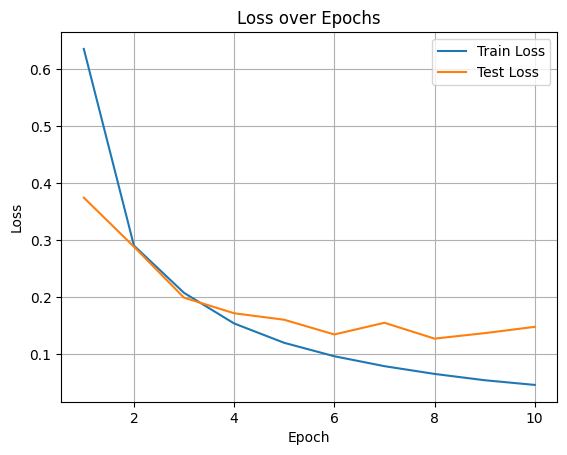

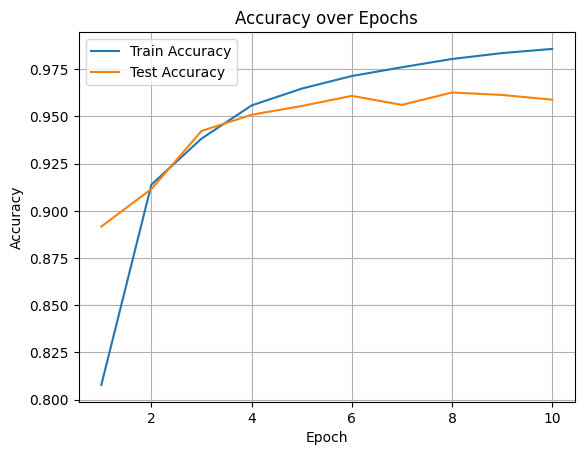

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# ------------------------
# 1) نمودار Loss
# ------------------------
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------
# 2) نمودار Accuracy
# ------------------------
plt.figure()
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


##  7. Visualizing Model Predictions

Let's display a few sample images from the test set  
along with the model's predicted label and the true label.


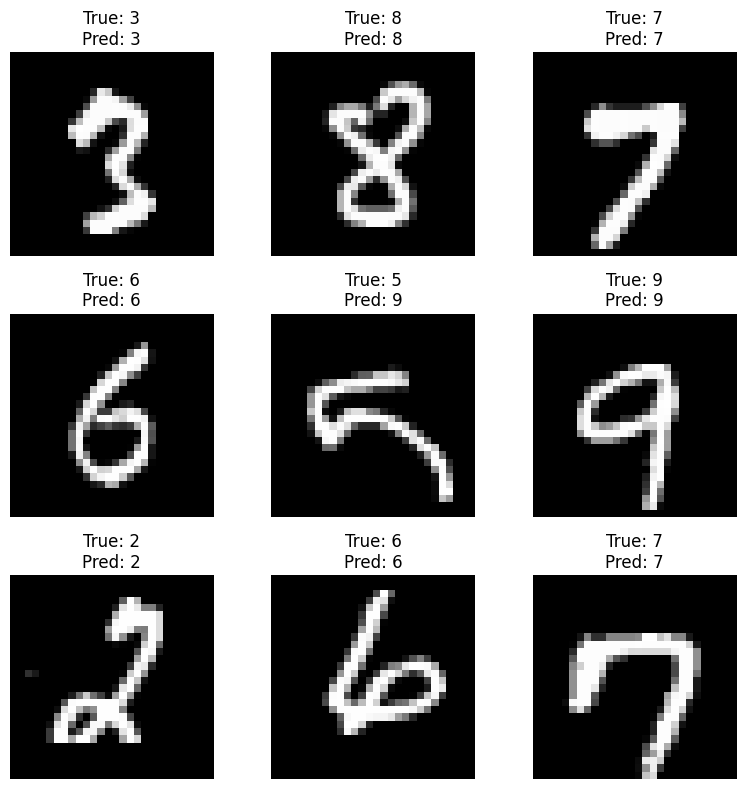

In [8]:

num_samples = 9
indices = np.random.choice(len(X_test), num_samples, replace=False)
x_samples = X_test[indices]
y_true_samples = np.argmax(y_test_oh[indices], axis=1)

# پیش‌بینی مدل روی این نمونه‌ها
logits_samples, _, _ = model.forward(x_samples)
y_pred_samples = np.argmax(softmax(logits_samples), axis=1)

# رسم تصاویر
plt.figure(figsize=(8, 8))
for i, idx in enumerate(indices):
    img = X_test[idx].reshape(28, 28) 

    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")

plt.tight_layout()
plt.show()


#  8. Conclusion

We successfully built a neural network **entirely from scratch**, including:

- Forward propagation  
- Backpropagation  
- Softmax + Cross-Entropy  
- Adam optimizer  

This implementation helps understand how neural networks **really work under the hood**,  
without using frameworks like TensorFlow or PyTorch.

---

**Next possible improvements (optional):**

- Xavier/He initialization  
- Dropout  
- Regularization (L2)  
- Early Stopping  
- BatchNorm  
